In [0]:
%pip install hdbscan

Python interpreter will be restarted.
Collecting hdbscan
 Downloading hdbscan-0.8.28.tar.gz (5.2 MB)
 Installing build dependencies: started
 Installing build dependencies: finished with status 'done'
 Getting requirements to build wheel: started
 Getting requirements to build wheel: finished with status 'done'
 Preparing wheel metadata: started
 Preparing wheel metadata: finished with status 'done'
Requirement already satisfied: joblib>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (1.0.1)
Requirement already satisfied: cython>=0.27 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (0.29.23)
Collecting numpy>=1.20
 Downloading numpy-1.22.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Requirement already satisfied: scipy>=1.0 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (1.6.2)
Requirement already satisfied: scikit-learn>=0.20 in /databricks/python3/lib/python3.8/site-packages (from hdbscan) (0.24.1)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit-learn>=0.20->hdbscan) (2.1.0)
Building wheels for collected packages: hdbscan
 Building wheel for hdbscan (PEP 517): started
 Building wheel for hdbscan (PEP 517): finished with status 'done'
 Created wheel for hdbscan: filename=hdbscan-0.8.28-cp38-cp38-linux_x86_64.whl size=3752117 sha256=22640e736380c4638691a8996b979a1c8e57d056a2482c46664f2ed5390d12f9
 Stored in directory: /root/.cache/pip/wheels/dc/71/35/27e492e5848c7d1b38a6ea86e10261fd7ebaabf7e72c0b47c4
Successfully built hdbscan
Installing collected packages: numpy, hdbscan
 Attempting uninstall: numpy
 Found existing installation: numpy 1.19.2
 Not uninstalling numpy at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-9a5dd68c-f394-4970-9a21-fdd9eb6c28ce
 Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.2 requires pyspark>=2.1.0, which is not installed.
tensorflow-cpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.3 which is incompatible.
numba 0.54.0 requires numpy<1.21,>=1.17, but you have numpy 1.22.3 which is incompatible.
Successfully installed hdbscan-0.8.28 numpy-1.22.3
WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-9a5dd68c-f394-4970-9a21-fdd9eb6c28ce/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
### Import libraries
import pandas as pd
import numpy as np
import itertools
from random import seed, choice

from matplotlib import pyplot as plt
import seaborn as sns

import hdbscan

In [0]:
# reading data from file
rubix5_eda = pd.read_csv('/dbfs/FileStore/onyshi1_rubix5_eda2.csv')

#target construction
#Target - CLAIM_COUNT_PAID / EARNED_EXPOSURES
rubix5_eda['TARGET'] = rubix5_eda['CLAIM_COUNT_PAID']/rubix5_eda['EARNED_EXPOSURES']
#Target_binary - 1 if CLAIM_COUNT_PAID > 0 else 0
rubix5_eda['TARGET_BINARY'] = rubix5_eda['CLAIM_COUNT_PAID'].apply(lambda x: 1 if x>0 else 0)


# apply filters - prepared by Julie, Thank you, Julie!
"""
    The Rubix 5 dataset is already limited to:
-Policies effective 1-1-2015 and later
-CSL only
-Power units only (no trailers)
-For Hire Trucking only (no public auto, business auto or garage)

Onyshchenko, Igor Additional filters needed will be SCHEDULED_FLEET = "YES" and COMPANY <> "FREEDOM SPECIALTY"
I think this covers it.  Let me know if anyone thinks I missed anything.
"""

rubix5_eda = rubix5_eda[rubix5_eda['SCHEDULED_FLEET']=="YES"]
rubix5_eda = rubix5_eda[rubix5_eda['COMPANY'] != 'FREEDOM SPECIALTY']

# there still was 'Brokerage Trans' and 'Business Auto' for I'm filtering it
rubix5_eda = rubix5_eda[rubix5_eda['VEHICLE_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]
rubix5_eda = rubix5_eda[rubix5_eda['POLICY_SEGMENT'].isin(['Large Fleet','Mid Fleet','Non Fleet'])]

#filtering earned exposures ==0 572 cases and <0 in 13 cases
rubix5_eda = rubix5_eda[rubix5_eda['EARNED_EXPOSURES'] > 0]

#filtering POLICYSTATE != 'HI' and 'MA'
rubix5_eda = rubix5_eda[rubix5_eda['POLICYSTATE'].isin(['HI', 'MA']) == False]

# filtering CLASS_CODE != 748900 - Non-Trucking 
rubix5_eda = rubix5_eda[rubix5_eda['CLASS_CD']!=748900]


# adding a column from Julie
rubix5_eda['REGION'] = rubix5_eda['POLICYSTATE'].copy()
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'CA', 'REGION'] = 'CALIFORNIA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'FL', 'REGION'] = 'FLORIDA' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'] == 'TX', 'REGION'] = 'TEXAS' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["CT","DE","MA","MD","ME","NH","NJ","NY","PA","RI","VA","VT","WV"]), 'REGION'] = 'EAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["IA","IL","IN","KS","KY","MI","MN","MO","ND","NE","OH","OK","SD","WI"]), 'REGION'] = 'MIDWEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AL","AR","GA","LA","MS","NC","SC","TN"]), 'REGION'] = 'SOUTHEAST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AZ","CO","ID","MT","NM","NV","OR","UT","WA","WY"]), 'REGION'] = 'WEST' 
rubix5_eda.loc[rubix5_eda['POLICYSTATE'].isin(["AK","HI"]), 'REGION'] = 'OTHER' 

#resetting indexes
rubix5_eda.reset_index(drop=True, inplace = True)
# del rubix5_eda['Unnamed: 0']
rubix5_eda.head()



Out[2]:

,Unnamed: 0,DOT_NUMBER,POLICYID,POLICY_EFF_DT,VEHICLE_NO,POLICY_EXP_DT,POLICYSTATUS,POLICYISSUETYPE,COMPANY,POLICYSTATE,STATE_ADMITTED,NEW_VENTURE,PKGCOMBO,YRSINBUSCT,YRSOFINSCT,POLICY_SEGMENT,OPERATION_EXPOSURE_POLICY,ZONE_GRPCD_POLICY,SCHEDULED_FLEET,VEHICLE_SEGMENT,VEHICLE_TERRITORY,VEHICLE_STATE,MODEL_YEAR,EQUIPMENT_AGE,VIN,RADIUS_GROUP,CLASS_CD,ZONE_GRPCD_VEHICLE,VEHICLE_ZIPCD,CLASS_PRIMARY,CLASS_SECONDARY,VEHICLE_TYPE,TRANSFORM_TERRITORY,TERRITORY_GRP,OPERATION_EXPOSURE_VEHICLE,EARNED_EXP_TRANS,EARNED_EXPOSURES,AVG_DRIVER_SURCHARGE,LIAB_SCHMOD,LIAB_EXPERIMOD,...,PREM_WRITTEN_EFF,PREM_EARNED_EFF,OLEP_TRANS,OLEP_EFF,COVERAGE_GROUP,INDEMNITY_PAID,INDEMNITY_INCURRED,EXPENSE_PAID,EXPENSE_INCURRED,LARGE_LOSSES_100K,LARGE_LOSSES_250K,LARGE_LOSSES_500K,LARGE_LOSSES_1M,LATE_REPORTED_CLAIMS,CLAIM_COUNT_PAID,CLAIM_COUNT_NOT_PAID,CRASH_SCORE,BASIC_ALERTS,DRIVER_INSPECTIONS,DRIVER_OUT_OF_SERVICE,DRIVER_OOS_RATIO,VEHICLE_INSPECTIONS,VEHICLE_OUT_OF_SERVICE,VEHICLE_OOS_RATIO,DRIVING_WITHOUT_CDL,DRIVING_WO_CDL_RATIO,MCS150_UNIT_COUNT,MILEAGE_POWER_UNIT_RATIO,DRIVER_POWER_UNIT_RATIO,HOT_ZONE_INsPECTIONS,HOT_ZONE_RATIO,PREVIOUS_INSURERS,LENGTH_WITH_PRIOR,CRASHES_SEASON_1,CRASHES_SEASON_2,CRASHES_SEASON_3,CRASHES_SEASON_4,TARGET,TARGET_BINARY,REGION
0,10,831876,CAI0038074,2015-02-24,4,2016-02-24,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,TX,A,3RD YR NEW VENTURE,AUTO LIABILITY & AUTO PD ONLY,19.0,3.0,Non Fleet,OTHER,NaN,YES,Non Fleet,21,TX,2007.0,6-15,1M2AG11C97M051901,LOCAL,404520.0,NaN,77701.0,Extra Heavy Local Non-fleet,Waste Disposal - Building Wrecking Operators,Extra Heavy Non Zone Truckers,21,TX03,OTHER,0.005479,0.005479,1.000,1.0,1.0,...,18.0,18.0,27.07,27.07,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,6.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,8029.333333,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0,TEXAS
1,11,Unknown,CAI0043676,2015-07-11,1,2016-07-11,Cancelled,Renewal,SCOTTSDALE INDEMNITY COMPANY,CA,A,OTHER,AUTO LIABILITY ONLY,5.0,NaN,Non Fleet,OTHER,NaN,YES,Non Fleet,6,CA,1985.0,Over 16,2XKWD29X7FM914742,LOCAL,331840.0,NaN,91505.0,Heavy Commercial Local Fleet,Contractors - Excavating,Heavy Commercial Non Zone Truckers,106,CA01,OTHER,0.000000,0.454795,1.100,1.0,1.0,...,1141.0,1141.0,2967.83,2968.82,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,CALIFORNIA
2,12,Unknown,CAI0043717,2016-06-04,3,2017-06-04,Renewed,New,SCOTTSDALE INDEMNITY COMPANY,TX,A,OTHER,AUTO LIABILITY & AUTO PD ONLY,16.0,11.0,Non Fleet,DUMPING,NaN,YES,Non Fleet,6,TX,2005.0,6-15,1M2B209C15M030264,LOCAL,404790.0,NaN,77662.0,Extra Heavy Local Non-fleet,Dump and Transit Mix - All Other,Extra Heavy Non Zone Truckers,6,TX03,DUMPING,1.000000,1.000000,1.115,1.0,1.0,...,3457.0,3457.0,3532.47,3532.47,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,TEXAS
3,14,643526,CAI0044410,2018-04-29,16,2019-04-29,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,KY,A,OTHER,AUTO LIABILITY & AUTO PD ONLY,48.0,NaN,Mid Fleet,WASTE DISP,NaN,YES,Mid Fleet,106,KY,2010.0,6-15,2NKHHN6X1AM267776,LOCAL,334530.0,NaN,40923.0,Heavy Commercial Local Non-fleet,Waste Disposal - Garbage,Heavy Commercial Non Zone Truckers,106,KY02,WASTE DISP,1.000000,1.000000,1.039,1.0,1.0,...,2051.0,2051.0,1983.32,1983.32,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,7.0,0.0,6.0,0.0,0.0,5.0,1.0,0.2,0.0,0.0,17.0,29.411765,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,MIDWEST
4,15,422450,CAI0048094,2015-10-25,30,2016-10-25,Renewed,Renewal,SCOTTSDALE INDEMNITY COMPANY,IL,A,OTHER,AUTO LIABILITY ONLY,16.0,NaN,Mid Fleet,OTHER,NaN,YES,Mid Fleet,137,IL,1996.0,Over 16,4V4JBAPE3TN843398,LOCAL,344990.0,NaN,60804.0,Heavy truck-tractors Service Local Non-fleet,Not Otherwise Specified - All Other,Yard Non Zone Truckers,137,IL01,OTHER,0.947945,0.947945,1.004,1.0,1.0,...,1263.0,1263.0,1256.95,1256.99,CSL,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,4.0,NaN,1.5,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,

In [0]:
#
# keep only features that can be used for modelling
# the list of features prepared by Amanpreet and checked by Jason and Tyler, Thank you guys!

selected_columns = ['POLICYID',
'POLICY_EFF_DT',
'POLICYSTATUS',
'COMPANY',
'NEW_VENTURE',
'PKGCOMBO',
'YRSINBUSCT',
'YRSOFINSCT',
'POLICYSTATE',
'POLICY_SEGMENT',
'SCHEDULED_FLEET',
'VEHICLE_SEGMENT',
'VEHICLE_STATE',
'MODEL_YEAR',
'EQUIPMENT_AGE',
'VIN',
'RADIUS_GROUP',
'ZONE_GRPCD_VEHICLE',
'VEHICLE_ZIPCD',
'VEHICLE_TYPE',
'TRANSFORM_TERRITORY',
'TERRITORY_GRP',
'OPERATION_EXPOSURE_VEHICLE',
'AVG_DRIVER_SURCHARGE',
'VEHICLE_COUNT',
'LIMIT_CSL',
'DEDUCTIBLE_LIAB_TYPE',
'DEDUCTIBLE_LIAB_AMT',
'EARNED_EXPOSURES',
'CLAIM_COUNT_PAID',
# CAB features
# 'CRASH_SCORE',
# 'BASIC_ALERTS',
# 'DRIVER_INSPECTIONS',
# 'DRIVER_OUT_OF_SERVICE',
# 'DRIVER_OOS_RATIO',
# 'VEHICLE_INSPECTIONS',
# 'VEHICLE_OUT_OF_SERVICE',
# 'VEHICLE_OOS_RATIO',
# 'DRIVING_WITHOUT_CDL',
# 'DRIVING_WO_CDL_RATIO',
# 'MCS150_UNIT_COUNT',
# 'MILEAGE_POWER_UNIT_RATIO',
# 'DRIVER_POWER_UNIT_RATIO',
# 'HOT_ZONE_INsPECTIONS',
# 'HOT_ZONE_RATIO',
# 'PREVIOUS_INSURERS',
# 'LENGTH_WITH_PRIOR',
# 'CRASHES_SEASON_1',
# 'CRASHES_SEASON_2',
# 'CRASHES_SEASON_3',
# 'CRASHES_SEASON_4',
'REGION'
]


df = rubix5_eda[selected_columns]

# initial feature engineering
df['POLICY_YEAR'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[:4]).astype('int')
df['POLICY_MONTH'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[5:7]).astype('int')

df['VIN_GRP1'] = df['VIN'].apply(lambda x: str(x)[:1])
df.loc[df['VIN_GRP1'].isin(['1','2','3','4','5'])==False, 'VIN_GRP1'] = 'OTHER'

df['VIN_GRP2'] = df['VIN'].apply(lambda x: str(x)[:2])
df.loc[df['VIN_GRP2'].isin(['3W', '2X', '3F', '5P', '2N', '2W', '3C', '5K', '2F', '1G', '3H',
                           '1N','1H','1M', '2H', '3A', '4V', '1F', '1X'])==False, 'VIN_GRP2'] = 'OTHER'

df['VIN_GRP3'] = df['VIN'].apply(lambda x: str(x)[:3])
df.loc[df['VIN_GRP3'].isin(['2HT','2XK','3HA','4V1','4V5','2FW','3FR','3WK', '3C7', '2NP', '2NK', '1GB', '1GC', '3C6', '4VG', '1GD', '5PV',
       '2WK', '2FZ', '2FU', '5KK', '5KJ', '1FT', '3AL', '1HS', '1FD', '1NK',
       '1M1', '1FV', '1M2', '1NP', '3HS', '1HT', '2HS', '3AK', '4V4', '1XK',
       '1XP', '1FU'])==False, 'VIN_GRP3'] = 'OTHER'

del df['VIN']
del df['POLICY_EFF_DT']

# MODEL AGE
df['MODEL_AGE'] = df['POLICY_YEAR'] - df['MODEL_YEAR'] + 1

# target definition
df['TARGET'] = df['CLAIM_COUNT_PAID'] / df['EARNED_EXPOSURES']
df['TARGET_BINARY'] = df['CLAIM_COUNT_PAID'].apply(lambda x: 1 if x>0 else 0)

df = df[df['POLICY_YEAR']<2022]



<command-7814193>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['POLICY_YEAR'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[:4]).astype('int')
<command-7814193>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['POLICY_MONTH'] = df['POLICY_EFF_DT'].apply(lambda x: str(x)[5:7]).astype('int')
<command-7814193>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP1'] = df['VIN'].apply(lambda x: str(x)[:1])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7814193>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP2'] = df['VIN'].apply(lambda x: str(x)[:2])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7814193>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['VIN_GRP3'] = df['VIN'].apply(lambda x: str(x)[:3])
/databricks/python/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._setitem_single_column(loc, value, pi)
<command-7814193>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['MODEL_AGE'] = df['POLICY_YEAR'] - df['MODEL_YEAR'] + 1
<command-7814193>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df['TARGET'] = df['CLAIM_COUNT_PAID'] / df['EARNED_EXPOSURES']
<command-7814193>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [0]:

# features for clastering
features = ['POLICYID','YRSINBUSCT', 'VEHICLE_COUNT']

# df on policy level
#filters - CALIFORNIA, 2017
state = 'CALIFORNIA'
policy_year = 2017

# Grouping for POLICY LEVEL CLUSTERING
tmp = df[(df['POLICY_YEAR']==policy_year) & (df['REGION']==state)].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})

tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']

tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)

tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp

Out[4]:

,POLICYID,REGION,POLICYSTATE,PKGCOMBO,YRSINBUSCT,VEHICLE_COUNT,CLAIM_COUNT_PAID,EARNED_EXPOSURES,VEHICLE_COUNT_GRP,YRSINBUSCT_GRP
0,CAI0048753,CALIFORNIA,CA,AUTO LIABILITY & AUTO PD ONLY,9.0,2.0,0,2.000000,"[2, 4)","(8.0, 11.0]"
1,CAI0054498,CALIFORNIA,CA,AUTO LIABILITY ONLY,9.0,5.0,0,3.490411,"[4, 10)","(8.0, 11.0]"
2,CAI0058968,CALIFORNIA,CA,AUTO LIABILITY ONLY,11.0,2.0,0,2.000000,"[2, 4)","(8.0, 11.0]"
3,CAI0058971,CALIFORNIA,CA,AUTO LIABILITY ONLY,7.0,3.0,0,1.000000,"[2, 4)","(6.0, 8.0]"
4,CAI0058972,CALIFORNIA,CA,AUTO LIABILITY & AUTO PD ONLY,7.0,5.0,0,3.000000,"[4, 10)","(6.0, 8.0]"
...,...,...,...,...,...,...,...,...,...,...
2997,OPS0068945,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,9.0,1.0,0,1.000000,"[1, 2)","(8.0, 11.0]"
2998,OPS0068946,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,5.0,1.0,0,1.000000,"[1, 2)","(4.0, 5.0]"
2999,OPS0068947,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,5.0,1.0,0,0.717808,"[1, 2)","(4.0, 5.0]"
3000,OPS0068948,CALIFORNIA,CA,AUTO LIAB/PD & MOTOR TRK CARGO,6.0,3.0,1,3.000000,"[2, 4)","(5.0, 6.0]"


In [0]:
# drop missings
print(tmp[features].isnull().sum())

#Dropping NA values as they are very less
tmp = tmp.dropna()
print(tmp.shape)

# Data Frame for Clustering
cluster_df = tmp[features]
cluster_df = cluster_df.reset_index(drop = True)
del cluster_df['POLICYID']
cluster_df

POLICYID 0
YRSINBUSCT 0
VEHICLE_COUNT 0
dtype: int64
(3001, 10)
Out[6]:

,YRSINBUSCT,VEHICLE_COUNT
0,9.0,2.0
1,9.0,5.0
2,11.0,2.0
3,7.0,3.0
4,7.0,5.0
...,...,...
2996,9.0,1.0
2997,5.0,1.0
2998,5.0,1.0
2999,6.0,3.0


In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import warnings

warnings.simplefilter('ignore')

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

# parameters
param_dist={'min_samples': [1,3,5,10,30,50], 'min_cluster_size': [200,300,400,500], 'cluster_selection_method': ['leaf'],
           'metric': ['euclidean', 'manhattan'], 'cluster_selection_epsilon': [0.2, 0.5, 1]}

# validity scorer
validity_scorer = make_scorer(hdbscan.validity.validity_index, greater_is_better = True)

SEED = 100
n_iter_search = 220 # >= min_samples * min_cluster_size * metric * cluster_selection_epsilon
random_search = RandomizedSearchCV(hdb, param_distributions = param_dist, n_iter = n_iter_search, scoring = validity_scorer, random_state = SEED)
random_search.fit(cluster_df)

print(f"Best Parameter {random_search.best_params_}")
print(f"DBCV score: {random_search.best_estimator_.relative_validity_}")



Best Parameter {'min_samples': 1, 'min_cluster_size': 200, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
DBCV score: 0.07697434188603798

Estimated number of clusters: 6
Estimated number of noise points: 641
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 641 3.171607 4.568425 12.842434 10.957666
 0 499 1.174349 0.452196 6.108216 1.008156
 1 216 3.023148 1.217860 5.986111 1.210340
 2 231 1.000000 0.000000 4.000000 0.000000
 3 618 1.673139 0.878313 2.870550 0.715247
 4 385 2.992208 2.364548 14.181818 3.106308
 5 411 1.223844 0.417327 10.051095 1.578767
Out[16]:

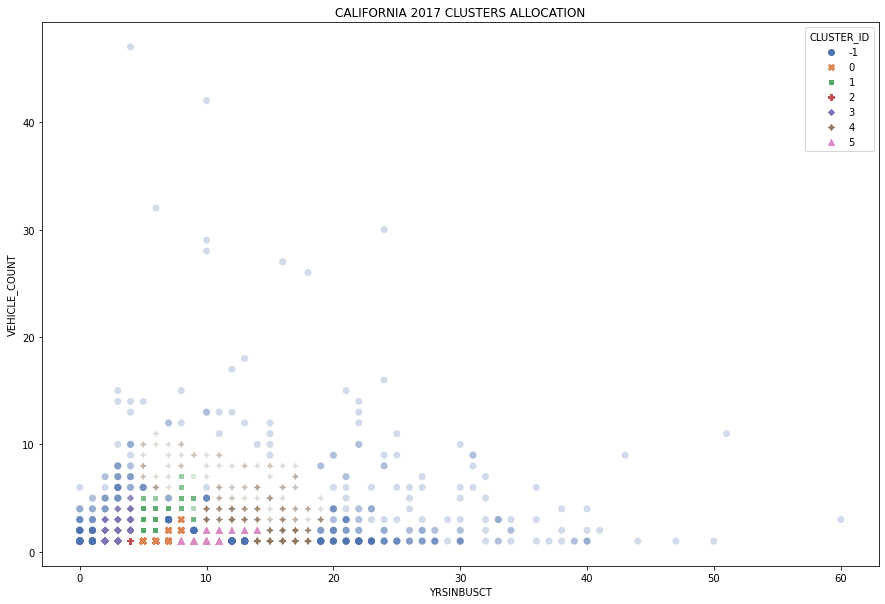

Text(0.5, 1.0, 'CALIFORNIA 2017 CLUSTERS ALLOCATION')

In [0]:
# Best Parameter {'min_samples': 1, 'min_cluster_size': 200, 'metric': 'euclidean', 'cluster_selection_method': 'leaf', 'cluster_selection_epsilon': 0.2}
# DBCV score: 0.07697434188603798

# changed min_cluster_size from 50 to 200 to decrease the number of noise (unclustered)
cluster = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=200, cluster_selection_epsilon = 0.2, metric='euclidean', cluster_selection_method = 'leaf', prediction_data=True)

cluster.fit_predict(cluster_df)

labels = cluster.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_df['CLUSTER_ID'] = labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = cluster_df.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

plt.figure(figsize = (15,10))
sns.scatterplot(x=cluster_df['YRSINBUSCT'], y=cluster_df['VEHICLE_COUNT'],data=cluster_df, s=50, linewidth=0, alpha=0.25, c=cluster_df['CLUSTER_ID'], style = 'CLUSTER_ID', hue='CLUSTER_ID', palette = 'deep')
plt.title('CALIFORNIA 2017 CLUSTERS ALLOCATION')

(786, 10)
Estimated number of clusters: 6
Estimated number of noise points: 158
 CLUSTER_ID VEHICLE_COUNT YRSINBUSCT 
 size mean std mean std
CLUSTER_ID 
-1 158 5.132911 4.679682 10.101266 9.776607
 0 126 1.309524 0.572214 6.198413 1.043225
 1 99 3.323232 1.202279 6.272727 1.376317
 2 58 1.000000 0.000000 4.000000 0.000000
 3 152 2.032895 1.069863 3.138158 0.700514
 4 96 3.833333 2.681974 12.479167 3.912138
 5 97 1.340206 0.476240 10.000000 1.581139
Out[17]:

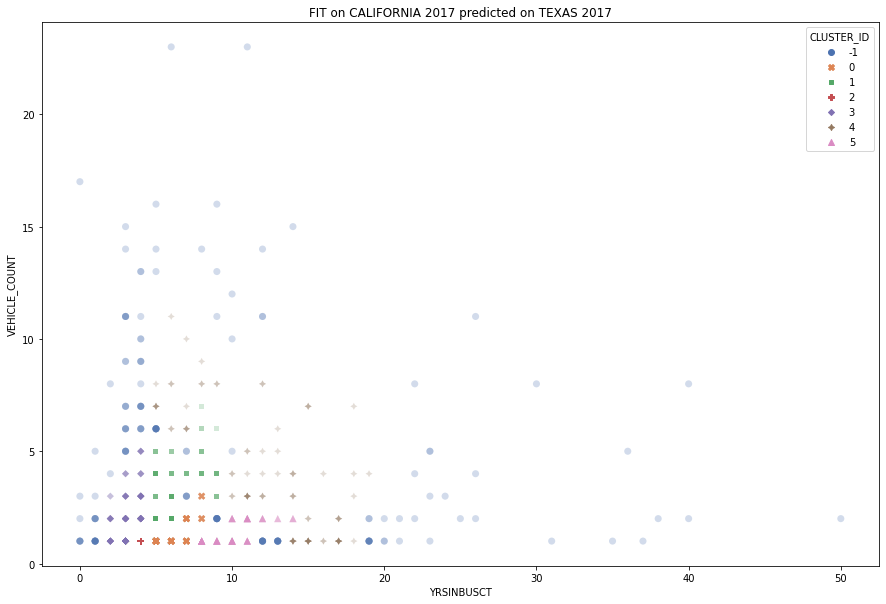

Text(0.5, 1.0, 'FIT on CALIFORNIA 2017 predicted on TEXAS 2017')

In [0]:
# prediction dataset for Texas 2017
# Filtering Parameters
state = 'TEXAS'
policy_year = 2017

#Preparing DataSet
tmp = df[(df['POLICY_YEAR']==policy_year) & (df['REGION']==state)].groupby('POLICYID').agg({'POLICYID': np.max,'REGION': np.max, 'POLICYSTATE': np.max, 'PKGCOMBO': np.max, 'YRSINBUSCT': np.max, 'VEHICLE_COUNT': np.max, 'CLAIM_COUNT_PAID': np.sum, 'EARNED_EXPOSURES': np.sum})
tmp.columns = ['POLICYID','REGION', 'POLICYSTATE', 'PKGCOMBO', 'YRSINBUSCT', 'VEHICLE_COUNT', 'CLAIM_COUNT_PAID', 'EARNED_EXPOSURES']
tmp = tmp.reset_index(drop=True)
tmp['VEHICLE_COUNT_GRP'] = pd.cut(tmp['VEHICLE_COUNT'], [1, 2, 4, 10, 25, 200], include_lowest = True, right = False)
tmp['YRSINBUSCT_GRP'] = pd.qcut(tmp['YRSINBUSCT'], 8)

tmp = tmp.dropna()
print(tmp.shape)
test_points = tmp[features]
test_points = test_points.reset_index(drop = True)
del test_points['POLICYID']

# Predicting CLusters
test_labels, strengths = hdbscan.approximate_predict(cluster, test_points)
test_labels


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(test_labels)) - (1 if -1 in test_labels else 0)
n_noise_ = list(test_labels).count(-1)

test_points['CLUSTER_ID'] = test_labels

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

t = test_points.groupby('CLUSTER_ID').agg({'CLUSTER_ID': np.size, 'VEHICLE_COUNT': [np.mean, np.std], 'YRSINBUSCT': [np.mean, np.std]})
print(t)

plt.figure(figsize = (15,10))
sns.scatterplot(x=test_points['YRSINBUSCT'], y=test_points['VEHICLE_COUNT'],data=test_points, s=50, linewidth=0, alpha=0.25, c=cluster_df['CLUSTER_ID'], style = 'CLUSTER_ID', hue='CLUSTER_ID', palette = 'deep')
plt.title('FIT on CALIFORNIA 2017 predicted on TEXAS 2017')

In [0]:
# normalazing VEHICLE_COUNT and YRSINBUSCT
from sklearn.preprocessing import StandardScaler,MinMaxScaler
standard = StandardScaler()
minMax = MinMaxScaler()

cluster_df[['YRSINBUSCT_STD','VEHICLE_COUNT_STD']] = standard.fit_transform(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])
cluster_df[['YRSINBUSCT_MM','VEHICLE_COUNT_MM']] = minMax.fit_transform(cluster_df[['YRSINBUSCT','VEHICLE_COUNT']])

cluster_df

In [0]:
plt.figure(figsize=(12,8))

sns.kdeplot(x=cluster_df['VEHICLE_COUNT'],hue=cluster_df['CLUSTER_ID'],data=cluster_df,palette=['grey','green','orange','brown','blue','red','pink'],fill=True)
plt.title('Distribution plot for vehicle count of CA policies in 2017 for Different cluster Ids')
plt.show()

for f in features:
  ...